Derived Diffusion Coefficient: 0.01795288836774153
Estimated Drift Term: 0.021954825632113765


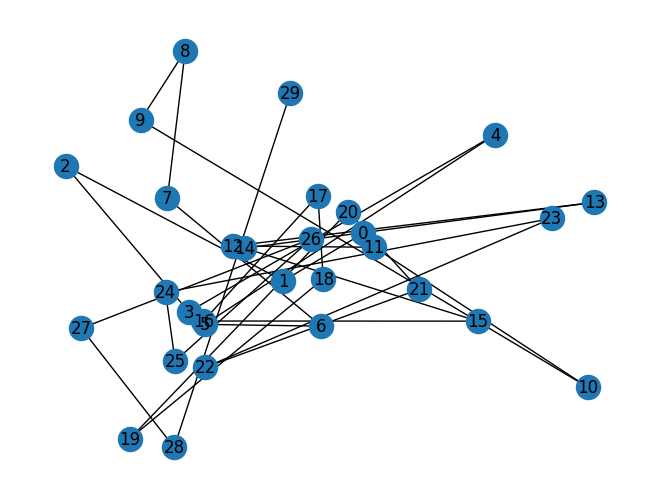

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define the polymer as a graph in NetworkX
def create_polymer_chain(length):
    G = nx.path_graph(length)
    pos = {i: (i, 0) for i in range(length)}
    nx.set_node_attributes(G, pos, 'pos')
    return G

# Step 2: Implement the PIMC method with coupling constants
def path_integral_monte_carlo(G, num_steps, beta, coupling_constants):
    positions = np.array([G.nodes[i]['pos'] for i in G.nodes])
    for step in range(num_steps):
        for i in range(len(positions)):
            old_pos = positions[i].copy()
            new_pos = old_pos + np.random.normal(scale=np.sqrt(beta), size=2)
            delta_energy = calculate_energy_change(G, i, old_pos, new_pos, coupling_constants)
            if np.random.rand() < np.exp(-beta * delta_energy):
                positions[i] = new_pos
                G.nodes[i]['pos'] = tuple(new_pos)
    return G

def calculate_energy_change(G, node, old_pos, new_pos, coupling_constants):
    neighbors = list(G.neighbors(node))
    delta_energy = 0
    for j, neighbor in enumerate(neighbors):
        neighbor_pos = np.array(G.nodes[neighbor]['pos'])
        delta_energy += coupling_constants[j] * ((np.linalg.norm(new_pos - neighbor_pos) - np.linalg.norm(old_pos - neighbor_pos)) ** 2)
    return delta_energy

# Step 3: Analyze the results to derive an SDE
def derive_sde(G):
    positions = np.array([G.nodes[i]['pos'] for i in G.nodes])
    displacements = np.diff(positions, axis=0)
    mean_square_displacement = np.mean(np.sum(displacements ** 2, axis=1))
    diffusion_coefficient = mean_square_displacement / (2 * len(G.nodes))
    
    # Compute drift term
    drift_term = compute_drift_term(G)
    
    return diffusion_coefficient, drift_term

def compute_drift_term(G):
    positions = np.array([G.nodes[i]['pos'] for i in G.nodes])
    displacements = np.diff(positions, axis=0)
    
    # Assuming the drift term is the average displacement per unit time
    mean_displacement = np.mean(np.sum(displacements, axis=1), axis=0)
    
    return mean_displacement

# Parameters
length = 30
num_steps = 1000
beta = 0.23
coupling_constants = np.random.uniform(0.1, 1.0, length-1)  # Random coupling constants between nodes

# Create polymer chain
G = create_polymer_chain(length)

# Perform PIMC with node-specific coupling constants
G = path_integral_monte_carlo(G, num_steps, beta, coupling_constants)

# Derive SDE results
diffusion_coefficient, drift_term = derive_sde(G)
print("Derived Diffusion Coefficient:", diffusion_coefficient)
print("Estimated Drift Term:", drift_term)

# Visualize the final configuration
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True)
plt.show()

In [2]:
# Function to simulate the SDE using the Euler-Maruyama method with drift term
def simulate_sde(D, drift_term, num_simulations, num_steps, dt):
    X = np.zeros((num_simulations, num_steps))
    for i in range(num_simulations):
        for t in range(1, num_steps):
            dW = np.sqrt(dt) * np.random.randn()
            X[i, t] = X[i, t-1] + drift_term * dt + np.sqrt(2 * D) * dW
    return X

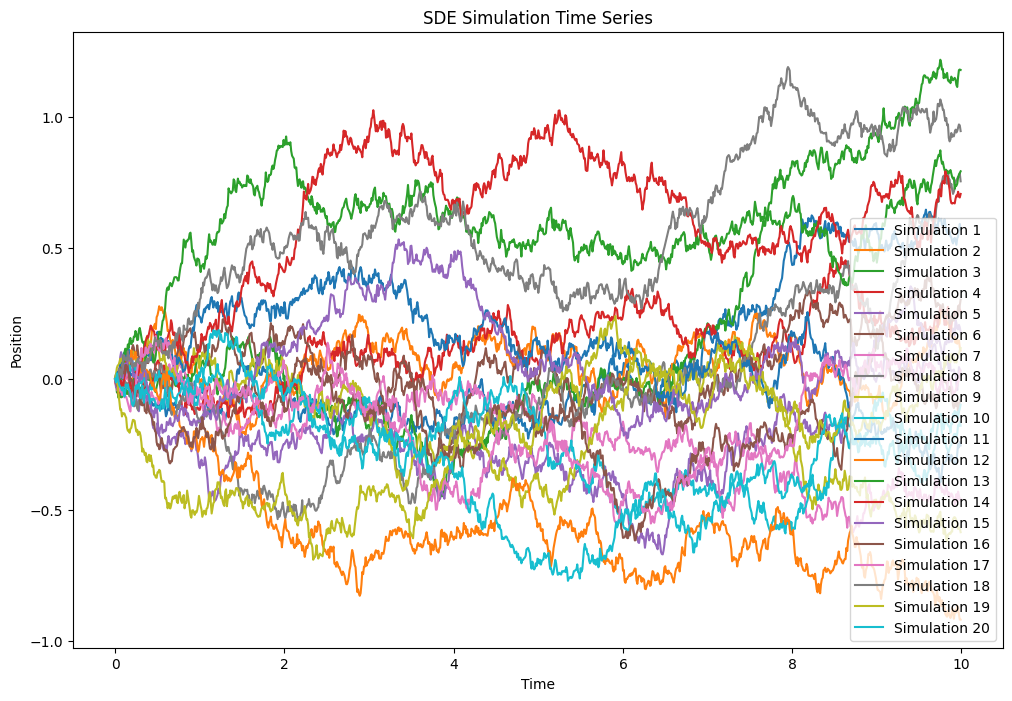

In [3]:
# Parameters for the SDE simulation
num_simulations = 20
num_steps = 1000
dt = 0.01
D = diffusion_coefficient  # Diffusion coefficient derived from PIMC
drift_term = drift_term   # Drift term derived from PIMC

# Plot simulations
X = simulate_sde(diffusion_coefficient, drift_term, num_simulations, num_steps, dt)

# Plot the first simulation
plt.figure(figsize=(12, 8))
for i in range(num_simulations):
    plt.plot(np.arange(num_steps) * dt, X[i], label=f'Simulation {i+1}')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('SDE Simulation Time Series')
plt.legend()
plt.show()

In [4]:
import seaborn as sns

# Function to compute the correlation matrix between time series
def compute_correlation_matrix(time_series):
    num_simulations, num_steps = time_series.shape
    flattened_time_series = time_series.T  # Transpose to get shape (num_steps, num_simulations)
    correlation_matrix = np.corrcoef(flattened_time_series, rowvar=False)
    return correlation_matrix

def plot_correlation_matrix(correlation_matrix, title="Correlation Matrix"):
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f", vmin=-1, vmax=1)
    plt.title(title)
    plt.xlabel('Simulation Index')
    plt.ylabel('Simulation Index')
    plt.show()

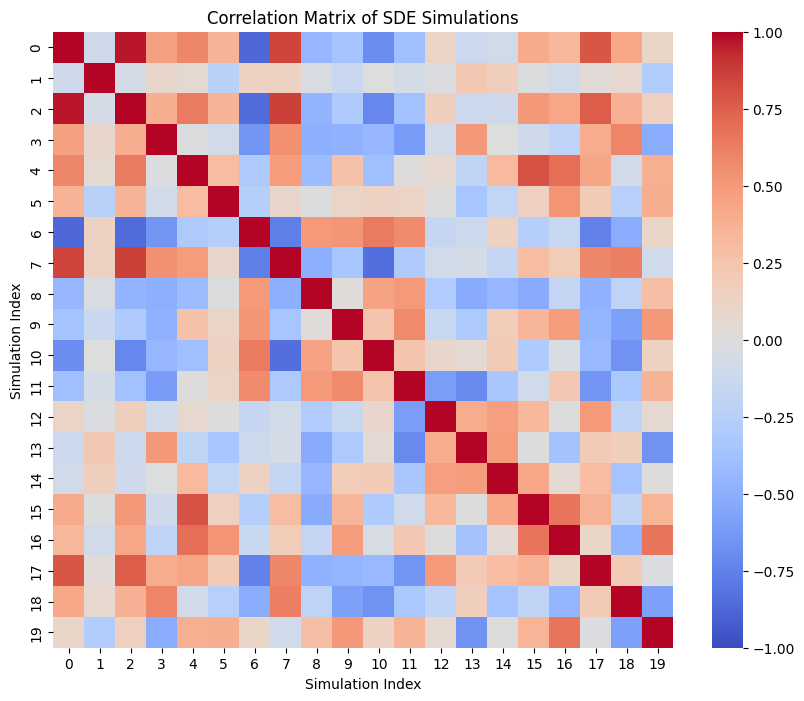

In [5]:
# Compute and plot the correlation matrix
correlation_matrix = compute_correlation_matrix(X)
plot_correlation_matrix(correlation_matrix, title='Correlation Matrix of SDE Simulations')